In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from py3langid.langid import LanguageIdentifier, MODEL_FILE
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

import warnings

# Suppress FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
train = pd.read_csv('data/competition_2024/subtask1.csv').drop(columns='Unnamed: 0')

train.head()

,id,text,label
0,15442,Es un tribunal de suprema instanza que forma p...,generated
1,26409,Aixó de tindrer la platgeta tant prou era un p...,human
2,12777,Doug mcadam es un científico estadista estadou...,generated
3,63467,"El president de la generalitat, carles puigdem...",generated
4,41050,"Traídas de francia, tan estrafalarias que una ...",generated


In [3]:
train.loc[0, 'text']

'Es un tribunal de suprema instanza que forma part de la jurisdiccion española, i és el principal organe judicial de catalunya, nacionals i comarcals. constitucionalmente, és el tribunal especial d"exercic de la judiccia catalana, és el que interpreta i defini la llei espanyola, i anull·la la seva aplicació en qualsevol cas o circunstancia, mitjançant la reforma del sistema legal català. és, a més, el tribunal especial d"exercic de la judiccia nacional catalana, és el que interpreta i s"applique la lex catalana, i que de nova es defineix per la constitució espanyola. és també un tribunal de recursos de catalunya, a la qual té afegit l"exercici del seu mandat en el fet que, al desenvolupament dels règims de la central bank of spain i de l"agència tributària de catalunya, es van aplicar els recursos de catalunya en les seves tasques. així, és un organisme obert al reconeixement de l"autogovern de catalunya, i es considera com a un tribunal de recursos, fins que aprové la constitución esp

In [4]:
identifier = LanguageIdentifier.from_pickled_model(MODEL_FILE)
identifier.set_languages(['en', 'es', 'pt', 'gl', 'eu', 'ca'])

# English (en)
# Spanish (es)
# Portuguese (pt)
# Galician (gl)
# Basque (eu)
# Catalan (ca)

identifier.classify(train.loc[0, 'text'])

('ca', -4691.199)

In [5]:
def detect_language(text):
    return identifier.classify(text)[0]

# Create the new column
train['detected_language'] = train['text'].apply(detect_language)

train

,id,text,label,detected_language
0,15442,Es un tribunal de suprema instanza que forma p...,generated,ca
1,26409,Aixó de tindrer la platgeta tant prou era un p...,human,ca
2,12777,Doug mcadam es un científico estadista estadou...,generated,es
3,63467,"El president de la generalitat, carles puigdem...",generated,ca
4,41050,"Traídas de francia, tan estrafalarias que una ...",generated,es
...,...,...,...,...
109658,76637,"Bere burua egokitzen saiatu zuen, aurreko mome...",generated,eu
109659,107183,"Benquerida compañeira e amiga, para nós é moi ...",human,gl
109660,144741,"The irish president has signed the ""long-await...",generated,en
109661,1202,"Pedro de alvarado y contreras ""tonatiuh"" (bada...",human,es


In [6]:
train['label'].value_counts()

label
generated    58754
human        50909
Name: count, dtype: int64

In [7]:
train['detected_language'].value_counts()

detected_language
en    25954
es    22535
pt    19733
ca    16372
eu    13444
gl    11625
Name: count, dtype: int64

In [8]:
train_en = train[train['detected_language'] == 'en']
train_es = train[train['detected_language'] == 'es']
train_pt = train[train['detected_language'] == 'pt']
train_gl = train[train['detected_language'] == 'gl']
train_eu = train[train['detected_language'] == 'eu']
train_ca = train[train['detected_language'] == 'ca']

In [9]:
import string
from nltk.corpus import stopwords

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = set(stopwords.words('english'))
    # STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

# import nltk 
# nltk.download('stopwords') # # -> do this in case of 'Resource stopwords not found.'


def preprocessing(df):
    # processing text
    df.loc[:, 'clean_text'] = df['text'].apply(text_process)

    # calculate text length
    df.loc[:, 'text_len'] = df.loc[:, 'clean_text'].apply(len)
    
    # crop unnecessary columns
    df = df.drop(columns=['text', 'detected_language'])

    # map labels
    df['label'] = df['label'].map({'human': 0, 'generated': 1})

    return df

In [10]:
train_en_preprocessed = preprocessing(train_en)

/var/folders/n2/wzhjvsf17gdbklls9d48pdl80000gn/T/ipykernel_46396/3353067110.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'clean_text'] = df['text'].apply(text_process)
/var/folders/n2/wzhjvsf17gdbklls9d48pdl80000gn/T/ipykernel_46396/3353067110.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'text_len'] = df.loc[:, 'clean_text'].apply(len)


In [11]:
train_en_preprocessed

,id,label,clean_text,text_len
7,100408,0,Another magnificent chapter nbchannibal seen c...,99
9,68184,0,Paul simon great artist multiple hits falls si...,265
11,123641,0,R hoarsely dont frightened fathers tumbled wat...,114
14,142133,1,Sri lanka set return 21 containers waste brita...,1129
15,134464,0,Milo lompar born 19 april 1962 serbian literar...,1476
...,...,...,...,...
109643,94952,0,Rtion every little however one dog another wou...,836
109647,1078,0,Mark xvii mark 17 often refers 17th version pr...,781
109654,122155,1,Marianne recovered injury changed woman gone l...,1246
109660,144741,1,irish president signed longawaiting mother bab...,1548


Text(0.5, 0, 'Message Length')

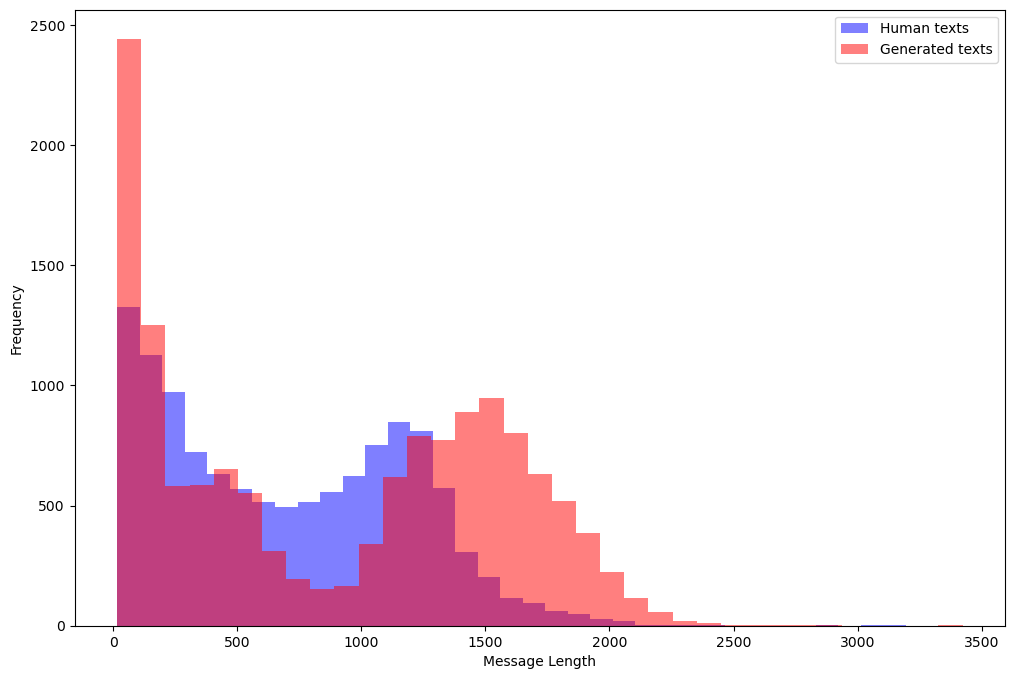

In [12]:
plt.figure(figsize=(12, 8))

train_en_preprocessed[train_en_preprocessed.label == 0].text_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Human texts', alpha=0.5)
train_en_preprocessed[train_en_preprocessed.label == 1].text_len.plot(bins=35, kind='hist', color='red', 
                                       label='Generated texts', alpha=0.5)
plt.legend()
plt.xlabel("Message Length")

In [13]:
def plot_common_words(ham_words, type):
    common_words = [word[0] for word in ham_words.most_common(20)]
    word_counts = [word[1] for word in ham_words.most_common(20)]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(common_words, word_counts, color='skyblue')
    plt.title(f'Top 20 Most Common Words in {type} Labeled Data')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [14]:
words = train_en_preprocessed[train_en_preprocessed.label == 0]['clean_text'].apply(lambda x: [word.lower() for word in x.split()])
ham_words_human = Counter()

for msg in words:
    ham_words_human.update(msg)
    
print(ham_words_human.most_common(50))

[('said', 10415), ('would', 5365), ('one', 5351), ('mr', 3904), ('also', 3593), ('people', 3499), ('first', 3253), ('time', 3058), ('could', 2988), ('new', 2884), ('like', 2871), ('two', 2746), ('well', 2312), ('see', 2218), ('made', 2171), ('years', 2143), ('us', 2132), ('good', 2106), ('may', 2075), ('much', 1938), ('know', 1853), ('last', 1807), ('book', 1797), ('year', 1791), ('many', 1748), ('little', 1720), ('man', 1717), ('say', 1683), ('great', 1666), ('get', 1645), ('come', 1609), ('work', 1588), ('go', 1579), ('make', 1576), ('back', 1540), ('dont', 1539), ('never', 1512), ('way', 1498), ('told', 1495), ('government', 1492), ('day', 1485), ('life', 1478), ('think', 1468), ('found', 1420), ('three', 1406), ('world', 1405), ('since', 1393), ('take', 1388), ('part', 1372), ('must', 1329)]


In [15]:
words = train_en_preprocessed[train_en_preprocessed.label == 1]['clean_text'].apply(lambda x: [word.lower() for word in x.split()])
ham_words_computer = Counter()

for msg in words:
    ham_words_computer.update(msg)
    
print(ham_words_computer.most_common(50))

[('also', 9429), ('said', 7367), ('one', 6012), ('would', 5611), ('new', 4685), ('could', 4208), ('time', 4119), ('including', 3603), ('made', 3561), ('people', 3482), ('many', 3399), ('help', 3299), ('life', 3269), ('however', 3231), ('like', 3223), ('known', 3197), ('man', 3158), ('first', 3061), ('world', 3044), ('work', 2983), ('mr', 2772), ('found', 2766), ('years', 2709), ('way', 2686), ('government', 2638), ('several', 2555), ('see', 2510), ('make', 2508), ('couldnt', 2497), ('eyes', 2476), ('local', 2475), ('significant', 2446), ('two', 2437), ('back', 2390), ('home', 2268), ('family', 2194), ('may', 2181), ('despite', 2175), ('city', 2157), ('knew', 2145), ('around', 2145), ('take', 2138), ('community', 2120), ('come', 2095), ('well', 2067), ('day', 2020), ('place', 2017), ('young', 2005), ('face', 1999), ('voice', 1913)]


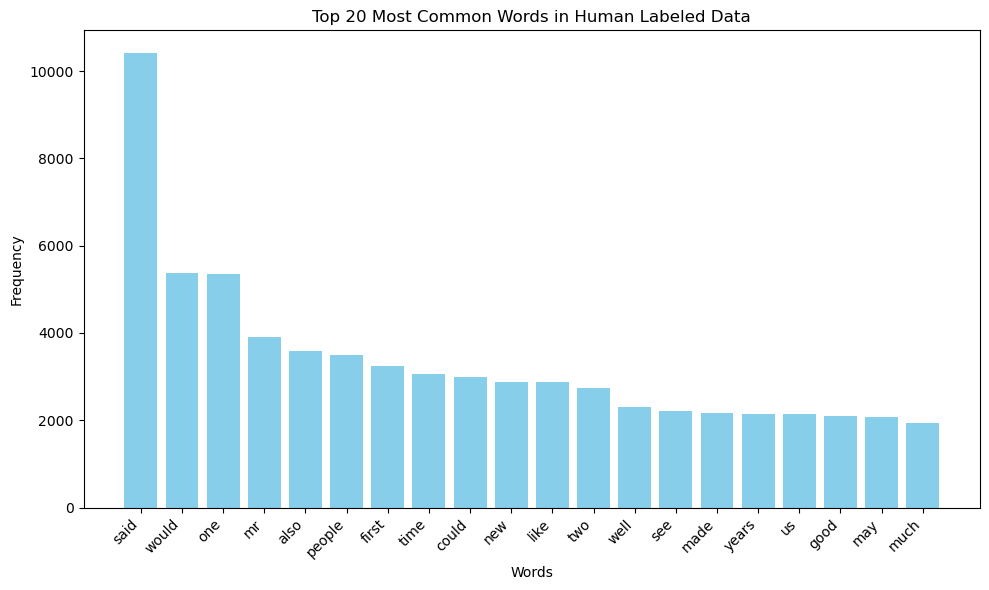

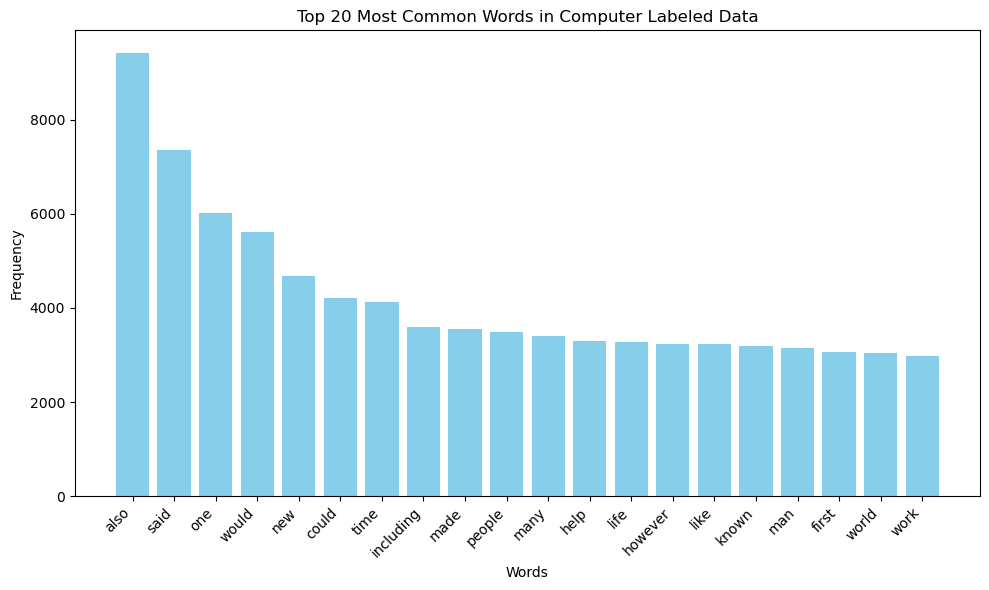

In [16]:
for counter in [(ham_words_human, 'Human'), (ham_words_computer, 'Computer')]:
    plot_common_words(counter[0], counter[1])

In [17]:
print(f"Average Human text length: {train_en_preprocessed[train_en_preprocessed.label == 0]['text_len'].mean()}")
print(f"Average Computer text length: {train_en_preprocessed[train_en_preprocessed.label == 1]['text_len'].mean()}")

Average Human text length: 705.5000837942015
Average Computer text length: 905.7903708987161


In [18]:
# train_en_preprocessed.loc[:, train_en_preprocessed.columns != 'label'
X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(train_en_preprocessed.loc[:, 'clean_text'], 
                                                                train_en_preprocessed['label'], test_size=0.20, random_state=42)

print(X_train_en.shape)
print(X_test_en.shape)
print(y_train_en.shape)
print(y_test_en.shape)

(20763,)
(5191,)
(20763,)
(5191,)


In [19]:
X_train_en

37725    Wasim sajjad born 30 march 1941 pakistani cons...
5335     rate one five stars due blatant manner trying ...
59459    review also looking ways reduce overproduction...
15330    Gerry adams sinn fein president paid tribute l...
92973    Tory new phase men science could never underst...
                               ...                        
90853    Public health infectious diseases regulations ...
22692    really liked characters thought honest warm fu...
3717     orange order called police answer serious ques...
66692    realized keeping feelings bottled made things ...
99894    quickly sat bed heart racing tried pinpoint so...
Name: clean_text, Length: 20763, dtype: object

In [20]:
y_train_en

37725    0
5335     0
59459    0
15330    1
92973    0
        ..
90853    1
22692    0
3717     1
66692    1
99894    1
Name: label, Length: 20763, dtype: int64

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(X_train_en)

# learn training data vocabulary, then use it to create a document-term matrix
X_train1_dtm = vect.transform(X_train_en)

# equivalently: combine fit and transform into a single step
X_train1_dtm = vect.fit_transform(X_train_en)


# examine the document-term matrix
print(type(X_train1_dtm), X_train1_dtm.shape)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test1_dtm = vect.transform(X_test_en)
print(type(X_test1_dtm), X_test1_dtm.shape)

<class 'scipy.sparse._csr.csr_matrix'> (20763, 112834)
<class 'scipy.sparse._csr.csr_matrix'> (5191, 112834)


In [22]:
# from sklearn.feature_extraction.text import TfidfTransformer

# tfidf_transformer = TfidfTransformer()
# tfidf_transformer.fit(X_train1_dtm)
# tfidf_transformer.transform(X_train1_dtm)

In [23]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [24]:
# train the model using X_train1_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train1_dtm, y_train_en)

CPU times: user 10 ms, sys: 2.03 ms, total: 12.1 ms
Wall time: 11.2 ms


MultinomialNB()

In [25]:
from sklearn import metrics

# make class predictions for X_test_dtm
y_test_en_pred_mb = nb.predict(X_test1_dtm)

# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test_en, y_test_en_pred_mb))

# print the confusion matrix
print("=======Confision Matrix===========")
metrics.confusion_matrix(y_test_en, y_test_en_pred_mb)

=======Accuracy Score===========
0.8489693700635715
=======Confision Matrix===========


array([[2029,  315],
       [ 469, 2378]])

In [26]:
from sklearn.metrics import f1_score
print(f"F1-score for Naive Bayes model: {f1_score(y_test_en, y_test_en_pred_mb, average='macro')}")

F1-score for Naive Bayes model: 0.8482835955545416


In [27]:
# import an instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear')

# train the model using X_train_dtm
%time logreg.fit(X_train1_dtm, y_train_en)

CPU times: user 49.2 s, sys: 14.1 s, total: 1min 3s
Wall time: 6.75 s


LogisticRegression(solver='liblinear')

In [28]:
# make class predictions for X_test_dtm
y_test_en_pred_lr = logreg.predict(X_test1_dtm)

# calculate predicted probabilities for X_test_dtm (well calibrated)
y_test_en_prob_lr = logreg.predict_proba(X_test1_dtm)[:, 1]
y_test_en_prob_lr

array([0.99944875, 0.06688525, 0.27554213, ..., 0.97010472, 0.38416115,
       0.99992185])

In [29]:
# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test_en, y_test_en_pred_lr))

# print the confusion matrix
print("=======Confision Matrix===========")
print(metrics.confusion_matrix(y_test_en, y_test_en_pred_lr))

# calculate AUC
print("=======ROC AUC Score===========")
print(metrics.roc_auc_score(y_test_en, y_test_en_pred_lr))

=======Accuracy Score===========
0.8572529377769216
=======Confision Matrix===========
[[1966  378]
 [ 363 2484]]
=======ROC AUC Score===========
0.8556172835066191


In [30]:
from sklearn.metrics import f1_score
print(f"F1-score for Logistic Regression model: {f1_score(y_test_en, y_test_en_pred_lr, average='macro')}")

F1-score for Logistic Regression model: 0.8558172140601767
